# 2nd workbook

In [1]:
import pandas as pd
import numpy as np
import os 
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
from importlib import reload

In [3]:
import wrangle as wr
import summaries as su
import model as m

In [4]:
df = wr.get_clean_data(start2018=True)

In [5]:
train, test = wr.split_data(df)

In [ ]:
train

In [ ]:
# take a look at value counts
columns = df.columns.to_list()
for i in columns:
    print(f'--------{i}-------')
    print(df[i].value_counts())
    print('___________________')
    

In [ ]:
def create_customertype_subgroups(train):
    
    types = train[['purchase_amount','customer_type']]
    k_12= types[types["customer_type"]=='K-12']
    local_gov = types[types["customer_type"]=='Local Government']
    state_agency = types[types["customer_type"]=='State Agency']
    higher_ed = types[types["customer_type"]=='Higher Ed']
    other = types[types['customer_type']=='Other']
    
    return k_12, local_gov, state_agency, higher_ed, other

In [ ]:
k_12, local_gov, state_agency, higher_ed, other = create_customertype_subgroups(train)

In [ ]:
k_12

# Explore subgroups

In [ ]:
df

In [ ]:
k_12.index

In [ ]:
k_12.isnull().sum()

In [ ]:
k_12.isnull().sum()

In [ ]:
def get_timeseries_plus(df):
    print(pd.plotting.autocorrelation_plot(df.resample('W').mean()))
    print (df.groupby([df.index.year, df.index.month]).mean().unstack(0).plot())
    print(df.groupby([df.index.year, df.index.day]).mean().unstack(0).plot())
    y = df.resample('W').mean()

    result = sm.tsa.seasonal_decompose(y)
    print(result.plot())

In [ ]:
get_timeseries_plus(k_12)

In [ ]:
su.get_customer_type_summary(train)

### time series at a glance

In [ ]:
plt.plot(train.index, train.purchase_amount)
plt.plot(test.index, test.purchase_amount)

### distribution of variables

In [ ]:
def distribution( df, var):
    ''' distribution takes in a dataframe and variable and returns a histoplot 
    that  display the distirbution of the variable'''
    # use histplot
    sns.histplot(df[var])
    #show plot
    plt.show();


In [ ]:
 train.columns.to_list()

# Average purchased sales/order quantity by month and sum by month

In [ ]:
ax = train.groupby(train.month).purchase_amount.sum().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Sum purchase amount by Month', xlabel='', ylabel='$')
plt.show()

### for total sales the month of July seems to be the largest next largest is to April

In [ ]:
ax = train.groupby(train.month).purchase_amount.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average purchase amount by Month', xlabel='', ylabel='$')
plt.show()

### for average sales december seems to have the most

In [ ]:
train[['purchase_amount','month']].groupby('month').describe()

In [ ]:
ax = train.groupby(train.month).order_quantity.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average order quantity by Month', xlabel='', ylabel='quantity')
plt.show()

### October has  a huge spike in order quantity

In [ ]:
ax = train.groupby(train.month).order_quantity.sum().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Sum order quantity by Month', xlabel='', ylabel='quantity')
plt.show()

In [ ]:
train[['order_quantity','month']].groupby('month').describe()

In [ ]:
sns.boxplot(data = train['2020'], x = 'month', y = 'purchase_amount')

# Question look into 2017-07-24 the day with the largest sale

In [ ]:
sdf = su.get_summary_df(train)

In [ ]:
sdf

In [ ]:
sdf.loc['2019-07-24'].purchase_amount.sum()

In [ ]:
sdf.loc['2019-07-24'].groupby('customer_type').sum()

### there was a large sale done my the k-12 group

In [ ]:
k_12_max = train[(train.customer_type=='K-12')&(train.order_date_copy=='2019-07-24')]

In [ ]:
k_12_max.groupby('customer_name').sum()

# Question: look into the day with the largest order date...right before pandemic

In [ ]:
sdf2 = su.get_summary_df(train)

In [ ]:
sdf2.loc['2020-01-02']

In [ ]:
def get_summary_orders_df(df):
    '''
    Groups by order date, customer name, customer type, customer city and reseller name.
    Calculates the purchase amount by the end. of the day
    
    Parameters:
        df: pandas data frame with the data pulled from DIR site
    Returns:
        pd.DataFrame with the sum of the purchase amount by the end of the day for every company
    '''
    summary_df = pd.DataFrame()
    if 'order_date_copy' in df.columns:
        summary_df = df.groupby(by=\
                        ['order_date_copy', 'customer_name', 'customer_type', 'customer_city', 'reseller_name', 'shipped_date'])\
                        .order_quantity.sum().to_frame().reset_index()
        summary_df.rename(columns={'order_date_copy':'order_date'}, inplace=True)
        summary_df = summary_df.set_index('order_date').sort_index()
    elif 'order_date' in df.columns:
        summary_df = df.groupby(by=\
                        ['order_date', 'customer_name', 'customer_type', 'customer_city', 'reseller_name', 'shipped_date'])\
                        .purchase_amount.sum().to_frame().reset_index()
        summary_df = summary_df.set_index('order_date').sort_index()  
    return summary_df

In [ ]:
orders = get_summary_orders_df(train)

In [ ]:
orders.loc['2020-01-02']

# modeling prep

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = wr.split_data(df, explore=False)

In [ ]:
train_series= train['purchase_amount']

### create model dataframe

In [ ]:
X_train

In [ ]:
model_df = df[['purchase_amount']]

<AxesSubplot:xlabel='order_date'>

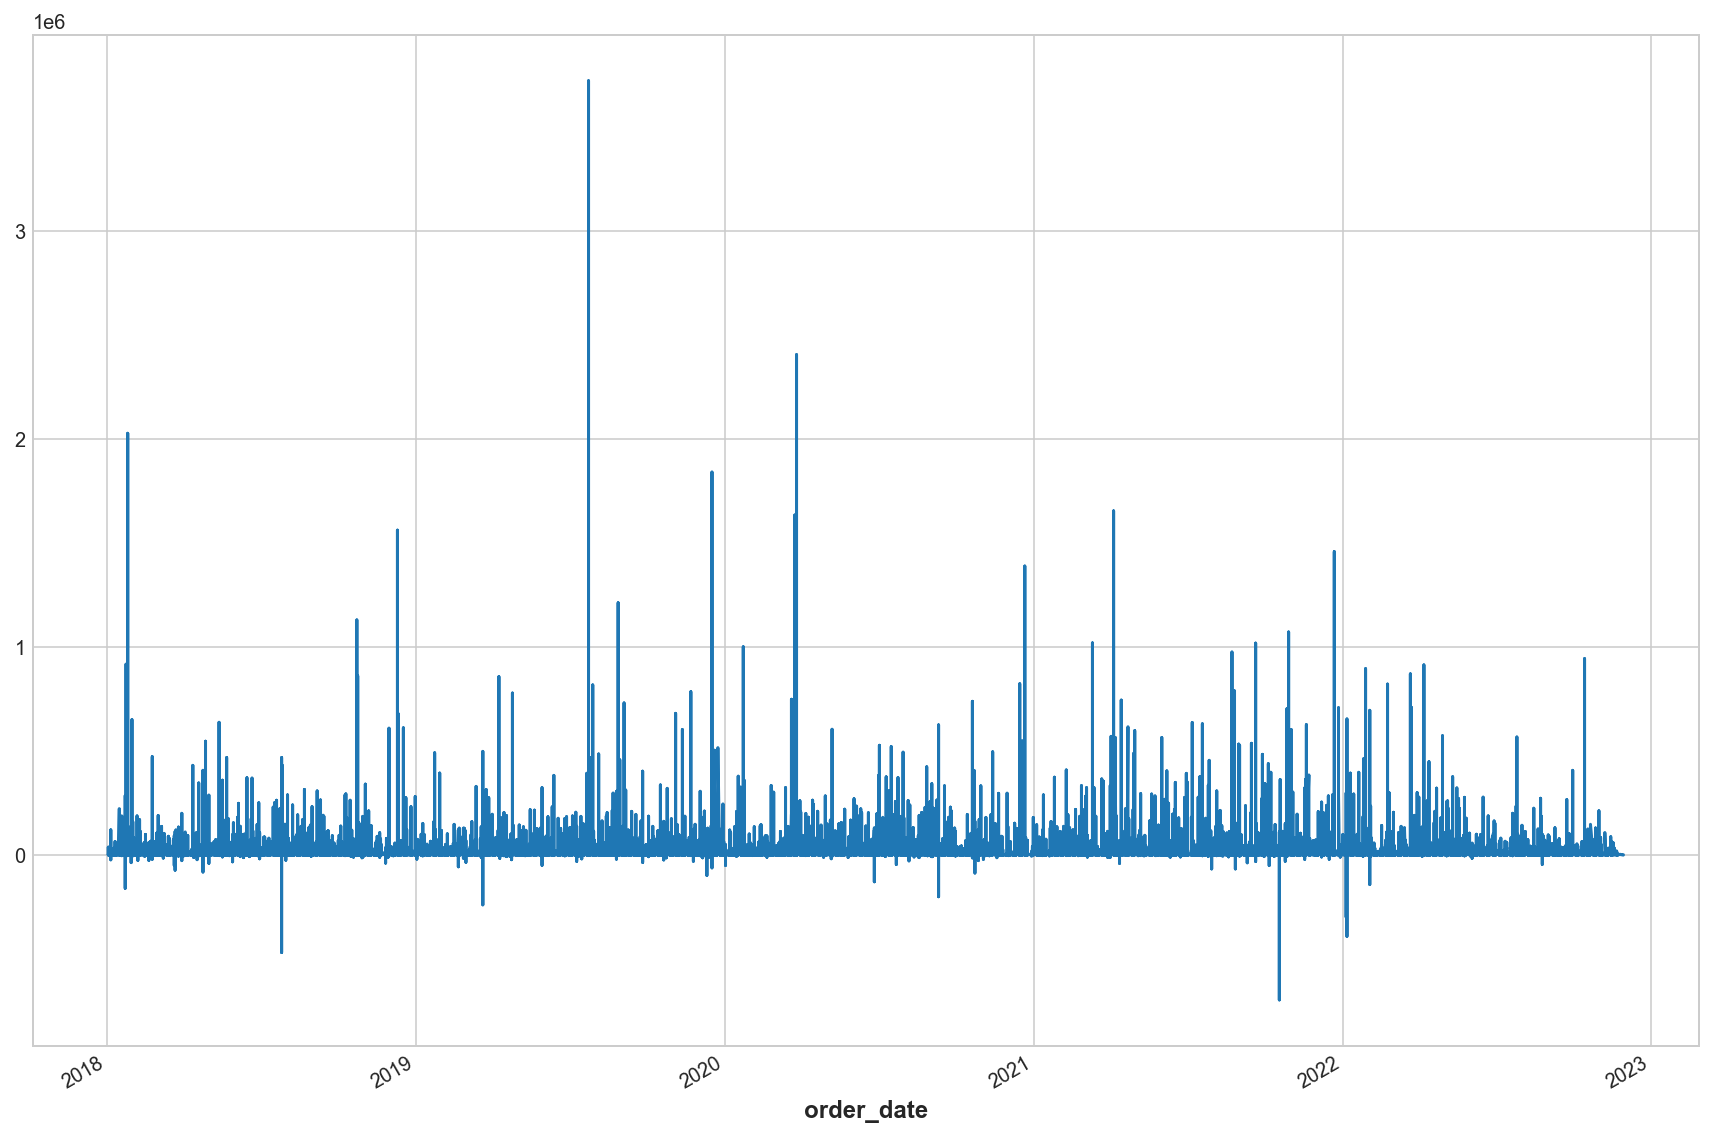

In [324]:
df.purchase_amount.plot(figsize=(12,8))

In [ ]:
model_df_weekly= model_df.resample("D").mean()

In [ ]:
model_df_weekly.plot(figsize=(12,8));

In [ ]:
model_df_weekly

In [ ]:
model_df_weekly['sale_last_week'] = model_df_weekly['purchase_amount'].shift(1)
model_df_weekly['sale_2weeks_back'] = model_df_weekly.purchase_amount.shift(2)
model_df_weekly['sale_3weeks_back'] = model_df_weekly.purchase_amount.shift(3)

In [ ]:
# train
#model_df_weekly[3:-101]
# validate
#model_df_weekly["2021"]
# test
#model_df_weekly[-49:]

In [ ]:
model_df_weekly

In [ ]:
lin_model = LinearRegression()
model = RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=400, random_state=123)

In [ ]:
best_random

In [50]:
train.shape

(235525, 20)

### split for train test

In [ ]:
x1,x2,x3,y = x1.reshape(-1, 1),  x2.reshape(-1, 1), x3.reshape(-1, 1),y.reshape(-1, 1)

In [ ]:
y=np.array(model_df_weekly.purchase_amount)
x1,x2,x3 = np.array(model_df_weekly.sale_last_week), np.array(model_df_weekly.sale_2weeks_back), np.array(model_df_weekly.sale_3weeks_back)

In [ ]:
final_x = np.concatenate((x1,x2,x3), axis = 1)


In [ ]:
# modeling
X_train, y_train, X_test, y_test = m.modeling_preprocessing(df, columns_to_keep=['customer_type', 'month_name','day_name', 'quarter'], regression=False, np_array=False)

In [ ]:
# cut off all null values start train at index 3
X_train, X_val, X_test, y_train,y_val, y_test = final_x[3:-101],final_x[-101:-49],final_x[-49:], y[3:-101],y[-101:-49],y[-49:]

In [ ]:
X_train

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False).fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

In [ ]:
# random Forest
model.fit(X_train, y_train)
# linear regression
lin_model.fit(X_train,y_train)

In [ ]:
pred=model.predict(X_test)
plt.plot(pred, label = 'Random Forest Predictions')
plt.plot(y_test, label='Actual sales')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
# RMSE
rmse_randomforest= sqrt(mean_squared_error(pred, y_test))
rmse_randomforest

In [ ]:
lin_pred=lin_model.predict(X_test)
plt.plot(lin_pred, label = 'Random Forest Predictions')
plt.plot(y_test, label='Actual sales')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
# RMSE
rmse_linear= sqrt(mean_squared_error(lin_pred, y_test))
rmse_linear

### with grid search

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)


In [ ]:
best_random = rf_random.best_estimator_

best_random



```python 
RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=800)
```

### find best for linear

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
GBR = GradientBoostingRegressor()

In [ ]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
              'max_depth'    : [4,6,8,10]
             }

In [ ]:
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

In [ ]:
grid_GBR_pred=grid_GBR.predict(X_val)
plt.plot(grid_GBR_pred, label = 'Predictions')
plt.plot(y_val, label='Actual sales')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
rmse_linear= sqrt(mean_squared_error(grid_GBR_pred, y_val))
rmse_linear

In [ ]:
import xgboost
print(xgboost.__version__)

# Model with Simple Average and Moving Average

### Simple Average

(order_date
 2018-01-02   4,532.00
 2018-01-02   2,860.00
 2018-01-02     187.04
 2018-01-02     428.96
 2018-01-02      63.36
                ...   
 2021-12-30   3,234.32
 2021-12-30     495.00
 2021-12-30     660.00
 2021-12-31     342.87
 2021-12-31     369.89
 Name: purchase_amount, Length: 235525, dtype: float64,
 order_date
 2018-01-02   4,532.00
 2018-01-02   2,860.00
 2018-01-02     187.04
 2018-01-02     428.96
 2018-01-02      63.36
                ...   
 2021-12-30   3,234.32
 2021-12-30     495.00
 2021-12-30     660.00
 2021-12-31     342.87
 2021-12-31     369.89
 Name: purchase_amount, Length: 235525, dtype: float64,
 order_date
 2022-01-01      872.56
 2022-01-01   32,728.16
 2022-01-01   98,250.00
 2022-01-01    8,152.38
 2022-01-01    2,237.84
                 ...   
 2022-11-25    2,469.24
 2022-11-28      430.00
 2022-11-28      525.78
 2022-11-29      418.96
 2022-11-29    1,376.48
 Name: purchase_amount, Length: 26361, dtype: float64,
 order_date
 2022-01-01    